In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
# from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import datetime

# Load Dataset

In [11]:
data = pd.read_csv('Data/005930.KS_5y.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-10-30,29700.0,30000.0,29680.0,30000.0,41.274914,10588400
1,2013-10-31,29960.0,30040.0,29300.0,29300.0,40.311840,12647050
2,2013-11-01,29800.0,30000.0,29360.0,30000.0,41.274914,11357700
3,2013-11-04,29840.0,30040.0,29780.0,29980.0,41.247398,10887800
4,2013-11-05,30040.0,30040.0,29440.0,29700.0,40.862167,8009300


# Compute Mid Price

In [12]:
high_prices = data['High'].values
low_prices = data['Low'].values
mid_prices = (high_prices + low_prices) / 2

In [13]:
data.shape

(1225, 7)

In [21]:
mid_prices.shape

(1225,)

# Create Windows

In [14]:
seq_len = 50
sequence_length = seq_len + 1

result = []
for index in range(len(mid_prices) - sequence_length):
    result.append(mid_prices[index: index + sequence_length])

In [15]:
result = np.array(result)
result.shape

(1174, 51)

# Normalize Data

In [16]:
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((1057, 50, 1), (117, 50, 1))

In [37]:
y_train.shape, y_test.shape

((1057,), (117,))

# Build a Model

In [18]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(50, 1)))

model.add(LSTM(64, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='rmsprop')

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


# Training

In [19]:
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=20)

Train on 1057 samples, validate on 117 samples
Epoch 1/20
1057/1057 [==============================] - 6s 6ms/step - loss: 0.0013 - val_loss: 5.9062e-04
Epoch 2/20
1057/1057 [==============================] - 5s 5ms/step - loss: 7.0774e-04 - val_loss: 4.0386e-04
Epoch 3/20
1057/1057 [==============================] - 5s 5ms/step - loss: 5.3703e-04 - val_loss: 4.3705e-04
Epoch 4/20
1057/1057 [==============================] - 5s 5ms/step - loss: 3.9595e-04 - val_loss: 4.4799e-04
Epoch 5/20
1057/1057 [==============================] - 5s 5ms/step - loss: 3.1342e-04 - val_loss: 1.6737e-04
Epoch 6/20
1057/1057 [==============================] - 5s 5ms/step - loss: 2.6423e-04 - val_loss: 5.1208e-04
Epoch 7/20
1057/1057 [==============================] - 5s 4ms/step - loss: 2.4957e-04 - val_loss: 1.6895e-04
Epoch 8/20
1057/1057 [==============================] - 4s 4ms/step - loss: 2.3094e-04 - val_loss: 1.6725e-04
Epoch 9/20
1057/1057 [==============================] - 5s 5ms/step - loss: 2

# Prediction of one data ahead(not training prediction result)

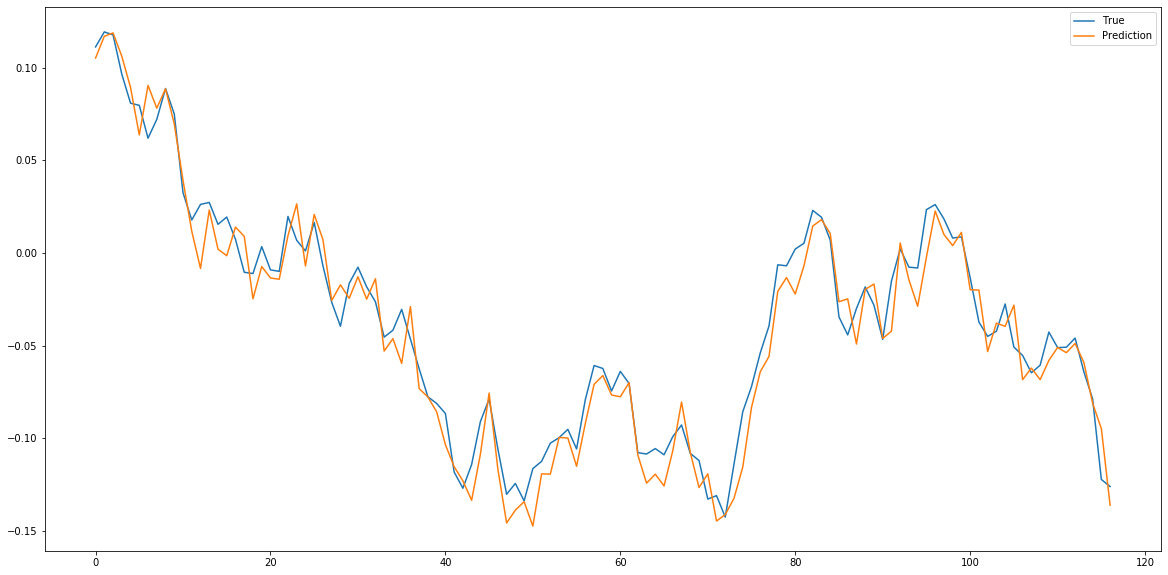

The Mean Absolute Error is: 0.010456847185647237


In [54]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()
MAE = mean_absolute_error(y_test, pred)
print('The Mean Absolute Error is: {}'.format(MAE))

# Prediction of one window ahead(training prediction result too)

In [23]:
x_train.shape

(1057, 50, 1)

In [39]:
x_test[0].shape

(50, 1)

In [55]:
def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[np.newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

predictions = predict_sequence_full(model, x_test, 50)

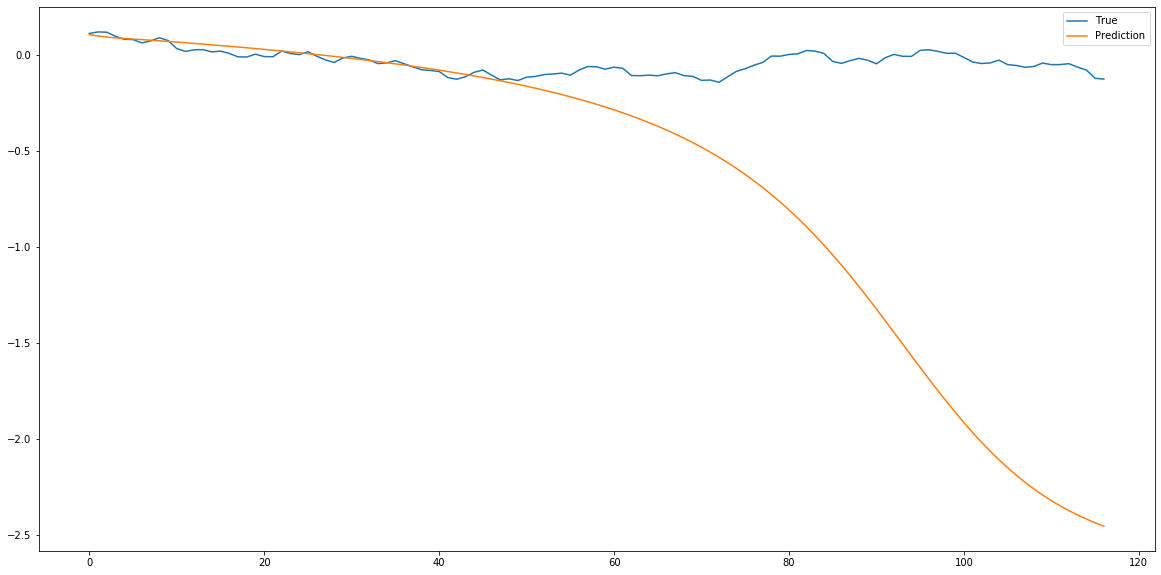

The Mean Absolute Error is: 0.6264766111713698


In [56]:
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(predictions, label='Prediction')
ax.legend()
plt.show()
MAE = mean_absolute_error(y_test, predictions)
print('The Mean Absolute Error is: {}'.format(MAE))

# LSTM does not solve prediction of stock price.